In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [2]:
molecules = ["SAG", "SHH", "PM", "CycA", "FGF2", "FGF4", "FGF8", "FGF17", "FGF19",
             "BMP4", "BMP7", "LDN", "Activin", "CHIR", "IWP2", "XAV", "Rspondin2",
             "Rspondin3", "RA", "SR11237", "DAPT", "EGF", "Insulin"]

## Fatima's data

In [3]:
#fatima = sc.read_h5ad("/pmount/projects/site/pred/organoid-atlas/USERS/fleckj/projects/juniper/data/datasets/FatimaPatterningScreen/240710_fatima_patscreen_v1_common_hv2k_wknn_ctrl_ref_mean.h5ad")
fatima = sc.read_h5ad("/projects/site/pred/organoid-atlas/data/local/perturbation/PatterningScreenFatima/fatima_patscreen_v1_common_hv2k_wknn.h5ad")
fatima_conds = pd.read_csv("/pmount/projects/site/pred/organoid-atlas/USERS/fleckj/projects/juniper/data/datasets/FatimaPatterningScreen/fatima_patscreen_conditions.tsv", sep="\t")

fatima = fatima[fatima.obs["Condition"].isin(fatima_conds["Condition"])]

In [4]:
mol_concs = {morph: [] for morph in molecules}
mol_start_times = {morph: [] for morph in molecules}
mol_end_times = {morph: [] for morph in molecules}
for i, row in fatima.obs.iterrows():
    cond = fatima_conds[fatima_conds["Condition"] == row["Condition"]].iloc[0]
    mols = [cond["Morphogen_AP"], cond["Morphogen_DV"], cond["Morphogen_F"]]
    mols_present = []
    for mol, ax in zip(mols, ["AP", "DV", "F"]):
        if mol != "-" and "_" not in mol:
            mol = mol if mol != "XAV939" else "XAV"
            mols_present.append(mol)
            mol_concs[mol].append(float(cond["Dose_" + ax + "_conc"]))
            start_time, end_time = cond["Timing_" + ax + "_days"].split("-")
            mol_start_times[mol].append(float(start_time))
            mol_end_times[mol].append(float(end_time))
        elif "_" in mol:
            mols_dv = mol.split("_")
            concs_dv = cond["Dose_DV_conc"].split("_")
            start_time, end_time = cond["Timing_DV_days"].split("-")
            for mol_dv, conc_dv in zip(mols_dv, concs_dv):
                mol = mol if mol != "XAV939" else "XAV"
                mols_present.append(mol_dv)
                mol_concs[mol_dv].append(float(conc_dv))
                mol_start_times[mol_dv].append(float(start_time))
                mol_end_times[mol_dv].append(float(end_time))

    # Other morphogens
    for mol in molecules:
        if not mol in mols_present:
            mol_concs[mol].append(0)
            mol_start_times[mol].append(0)
            mol_end_times[mol].append(0)

In [5]:
for mol in molecules:
    fatima.obs[mol + "_conc"] = mol_concs[mol]
    fatima.obs[mol + "_start_time"] = mol_start_times[mol]
    fatima.obs[mol + "_end_time"] = mol_end_times[mol]

/tmp/ipykernel_2948049/3748026991.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  fatima.obs[mol + "_conc"] = mol_concs[mol]


In [6]:
# nM to ng/mL (molecular weights: BMP4=13kDa, BMP7=15.7kDa - Fatima used monomers)
fatima.obs["BMP4_conc"] = fatima.obs["BMP4_conc"] * 13
fatima.obs["BMP7_conc"] = fatima.obs["BMP7_conc"] * 15.7

# nM to uM
fatima.obs.loc[fatima.obs["XAV_conc"] == 180, "XAV_conc"] = 0.18

## Neal Amin's data

In [7]:
neal = sc.read_h5ad("/projects/site/pred/organoid-atlas/data/public_datasets/scg/brain_organoids/AminPasca2023brx/pasca_primary_screen_v1_common_hv2k_wknn.h5ad")
neal_conds = pd.read_csv("/pmount/projects/site/pred/organoid-atlas/USERS/bobrovsd/data/amin/amin_conditions_rt.csv")

In [8]:
mol_concs = {morph: [] for morph in molecules}
mol_start_times = {morph: [] for morph in molecules}
mol_end_times = {morph: [] for morph in molecules}
for i, row in neal.obs.iterrows():
    cond = neal_conds[neal_conds["cond_id"] == row["condition"]].iloc[0]
    mols = cond[~cond.isna()]
    mol_names = mols.index[~mols.index.isin(['condition', 'cond_id', 'dataset'])]
    mol_names = mol_names[~mol_names.str.contains("_")]
    for mol in molecules:
        if mol in mol_names:
            mol_concs[mol].append(mols[mol])
            mol_start_times[mol].append(mols[mol + "_start"])
            mol_end_times[mol].append(mols[mol + "_end"])
        else:
            mol_concs[mol].append(0)
            mol_start_times[mol].append(0)
            mol_end_times[mol].append(0)

In [9]:
for mol in molecules:
    neal.obs[mol + "_conc"] = mol_concs[mol]
    neal.obs[mol + "_start_time"] = mol_start_times[mol]
    neal.obs[mol + "_end_time"] = mol_end_times[mol]

## Midbrain data

In [3]:
nadya = sc.read_h5ad("/projects/site/pred/organoid-atlas/data/local/perturbation/MidbrainPatterningNadya/midbrain_patterning_v2_common_hv2k_wknn.h5ad")
nadya_conds = pd.read_csv("/projects/site/pred/organoid-atlas/USERS/bobrovsd/data/nadya/midbrain_conditions.csv", index_col=0)

In [4]:
mol_concs = {morph: [] for morph in molecules}
mol_start_times = {morph: [] for morph in molecules}
mol_end_times = {morph: [] for morph in molecules}
count = 0
d = {}
d[0] = []
for i, row in nadya.obs.iterrows():
    if count == 3:
        break
    cond = nadya_conds[nadya_conds["Condition"] == int(row["Condition"])].iloc[0]
    mols = cond[cond != 0]
    mol_names = mols.index[~mols.index.isin(['Condition'])]
    mol_names = mol_names.str.replace("M_", "").str.replace("_d.*","", regex=True).unique()
    for mol in molecules:
        if mol == "PM":
            if "SHH" in mol_names:
                if mols["M_SHH"] == 5:
                    mol_concs[mol].append(2000)
                    mol_start_times[mol].append(1)
                    mol_end_times[mol].append(8)
                elif mols["M_SHH"] == 1:
                    mol_concs[mol].append(400)
                    mol_start_times[mol].append(1)
                    mol_end_times[mol].append(8)
            else:
                mol_concs[mol].append(0)
                mol_start_times[mol].append(0)
                mol_end_times[mol].append(0)
        elif mol == "LDN":
            mol_concs[mol].append(100)
            if "BMP4" in mol_names:
                mol_start_times[mol].append(1)
                mol_end_times[mol].append(8)
            else:
                mol_start_times[mol].append(1)
                mol_end_times[mol].append(15)
        elif mol == "CHIR":
            if row["Condition"] == '4':
                mol_concs[mol].append(0.8)
            else:
                mol_concs[mol].append(3)
            mol_start_times[mol].append(5)
            mol_end_times[mol].append(15)
        elif mol not in mol_names:
            mol_concs[mol].append(0)
            mol_start_times[mol].append(0)
            mol_end_times[mol].append(0)
        elif mol == "SHH":
            mol_concs[mol].append(mols["M_SHH"])
            mol_start_times[mol].append(1)
            mol_end_times[mol].append(8)
        elif mol in ["FGF8", "FGF2", "FGF17"]:
            fgf_cols = np.array(["M_" + mol + "_d1_8", "M_" + mol + "_d8_15"])
            if np.all(np.isin(fgf_cols, mols.index)):
                concs = mols[fgf_cols].tolist()
                if concs[0] == concs[1]:
                    mol_concs[mol].append(concs[0] * 100)
                    mol_start_times[mol].append(1)
                    mol_end_times[mol].append(15)
                else:
                    mol_concs[mol].append(str(concs[0] * 100) + "_" + str(concs[1] * 100))
                    mol_start_times[mol].append("1_8")
                    mol_end_times[mol].append("8_15")
            elif np.any(np.isin(fgf_cols, mols.index)):
                fgf_col = fgf_cols[np.isin(fgf_cols, mols.index)]
                mol_concs[mol].append(mols[fgf_col].values[0] * 100)
                mol_start_times[mol].append(int(fgf_col[0].split("_d")[1].split("_")[0]))
                mol_end_times[mol].append(int(fgf_col[0].split("_")[3]))
            else:
                mol_concs[mol].append(0)
                mol_start_times[mol].append(0)
                mol_end_times[mol].append(0)
        elif mol == "Insulin":
            mol_concs[mol].append(mols["M_Insulin"])
            mol_start_times[mol].append(1)
            mol_end_times[mol].append(15)
        elif mol in ["BMP4", "RA", "Rspondin2", "Rspondin3"]:
            mol_concs[mol].append(mols["M_" + mol])
            mol_start_times[mol].append(8)
            mol_end_times[mol].append(15)
        elif mol == "FGF19":
            mol_concs[mol].append(mols["M_FGF19"])
            mol_start_times[mol].append(15)
            mol_end_times[mol].append(36)

In [5]:
for mol in molecules:
    nadya.obs[mol + "_conc"] = mol_concs[mol]
    nadya.obs[mol + "_start_time"] = mol_start_times[mol]
    nadya.obs[mol + "_end_time"] = mol_end_times[mol]

In [6]:
# to ng/mL
nadya.obs["SHH_conc"] = nadya.obs["SHH_conc"]*20
nadya.obs["FGF19_conc"] = nadya.obs["FGF19_conc"]*100
# nM to ng/mL (molecular weights: BMP4=26kDa, BMP7=31.4kDa - Nadya used dimers)
nadya.obs["BMP4_conc"] = nadya.obs["BMP4_conc"]*26
nadya.obs["BMP7_conc"] = nadya.obs["BMP7_conc"]*31.4
# to nM
nadya.obs["RA_conc"] = nadya.obs["RA_conc"]*100
# to ug/mL
nadya.obs["Insulin_conc"] = nadya.obs["Insulin_conc"]*7

## Merged data

In [15]:
fatima_with_ctrl = sc.read_h5ad("/pmount/projects/site/pred/organoid-atlas/USERS/fleckj/projects/juniper/data/datasets/FatimaPatterningScreen/240710_fatima_patscreen_v1_common_hv2k_wknn_ctrl_ref_mean.h5ad")
ctrl = fatima_with_ctrl[fatima_with_ctrl.obs["CTRL"]]

In [16]:
fatima = fatima[:, []]
neal = neal[:, []]
nadya = nadya[:, []]
ctrl = ctrl[:, []]

# merge ctrl, fatima, neal, nadya
adata = ad.concat([ctrl, fatima, neal, nadya], join="outer")
adata.obs_names_make_unique()
adata.obs = adata.obs.drop(columns=[col for col in adata.obs.columns if not np.any(["_start_time" in col, "_end_time" in col, "_conc" in col])])
adata.obs[adata.obs.isna()] = 0.0
adata.obs[adata.obs == 0] = 0.0
adata.obs = adata.obs.astype(str)
adata.obs["dataset"] = ["ctrl"] * ctrl.n_obs + ["fatima"] * fatima.n_obs + ["neal"] * neal.n_obs + ["nadya"] * nadya.n_obs
adata.obs["source"] = '0'
adata.obs["CTRL"] = adata.obs["dataset"] == "ctrl"
adata.obsm = {"X_latent": adata.obsm["X_scanvi_braun"]}
adata.uns = {"dataset": {'ctrl': [0, 0, 0, 0, 0, 0, 0],
                         'fatima': [0, 0, 1, 0, 0, 0, 0],
                         'neal': [0, 1, 0, 0, 0, 0, 0],
                         'nadya': [1, 0, 0, 0, 0, 0, 0]}}

/home/bobrovsd/miniconda3/envs/cellflow/lib/python3.10/site-packages/anndata/_core/merge.py:1284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
/home/bobrovsd/miniconda3/envs/cellflow/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
adata.write_h5ad("/pmount/projects/site/pred/organoid-atlas/USERS/bobrovsd/data/morphogens/organoids_all.h5ad")

In [42]:
# pca of cells based on morphogen concentrations and timing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df_pca = pd.DataFrame(index=adata.obs_names, columns=molecules)
for mol in molecules:
    df_pca[mol] = adata.obs[mol + "_conc"]
    df_pca[mol + "_start_time"] = adata.obs[mol + "_start_time"]
    df_pca[mol + "_end_time"] = adata.obs[mol + "_end_time"]
df_pca = df_pca.fillna(0)
# convert str to float; if cannot convert, drop row
df_pca = df_pca.applymap(lambda x: (np.nan if "_" in x else float(x)) if isinstance(x, str) else x)
dataset = adata.obs["dataset"]
dataset = np.array([np.array(["ctrl", "fatima", "neal", "nadya"])[int(i)] for i in dataset])

# filter na
dataset = dataset[~df_pca.isna().any(axis=1)]
df_pca = df_pca.dropna()

scaler = StandardScaler()
X = scaler.fit_transform(df_pca)
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

/tmp/ipykernel_3627575/460049955.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pca = df_pca.applymap(lambda x: (np.nan if "_" in x else float(x)) if isinstance(x, str) else x)


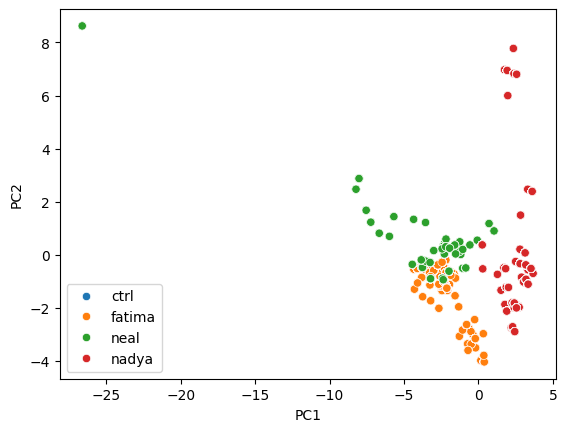

In [43]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dataset, palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [47]:
# fig, axs = plt.subplots(6, 4, figsize=(20, 30))

# for i, mol in enumerate(molecules):
#     ax = axs[i // 4, i % 4]
#     sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_pca[mol], palette="viridis", ax=ax)
#     ax.set_title(mol)
#     ax.set_xlabel("PC1")
#     ax.set_ylabel("PC2")